# Import Packages

Note: Dataset menggunakan data berikut: https://www.kaggle.com/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset/data

In [2]:
%config Completer.use_jedi = False
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import seaborn as sns
import cv2
import random
import os
import imageio
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, RepeatedStratifiedKFold
from imblearn.over_sampling import SMOTE

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.applications import resnet
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
from keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

In [3]:
directory = r'./dataset/'
categories = ['Bengin cases', 'Malignant cases', 'Normal cases']

# Image Size Variations

In [ ]:
size_data = {}
for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    temp_dict = {}
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        height, width, channels = imageio.imread(filepath).shape
        if str(height) + ' x ' + str(width) in temp_dict:
            temp_dict[str(height) + ' x ' + str(width)] += 1 
        else:
            temp_dict[str(height) + ' x ' + str(width)] = 1
    
    size_data[i] = temp_dict
        
size_data

Bengin cases


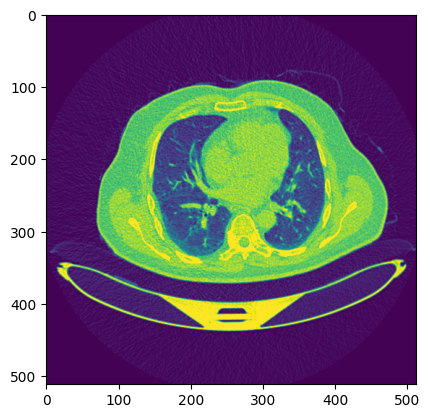

Malignant cases


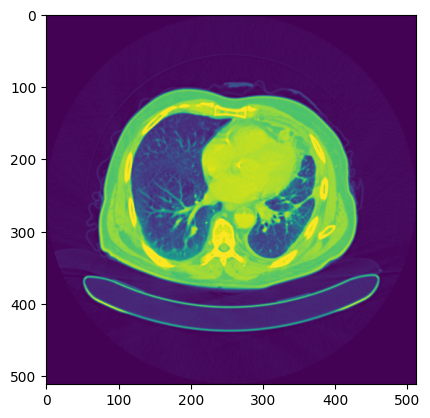

Normal cases


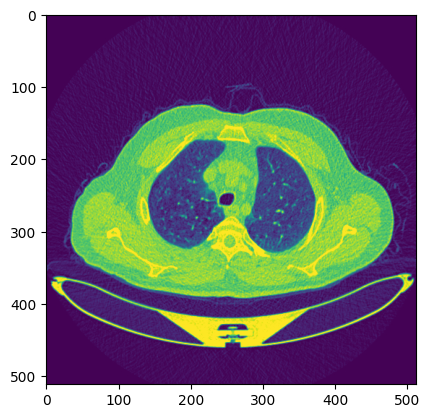

In [5]:
for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        print(i)
        img = cv2.imread(filepath, 0)
        plt.imshow(img)
        plt.show()
        break

# Image Preprocessing and Testing

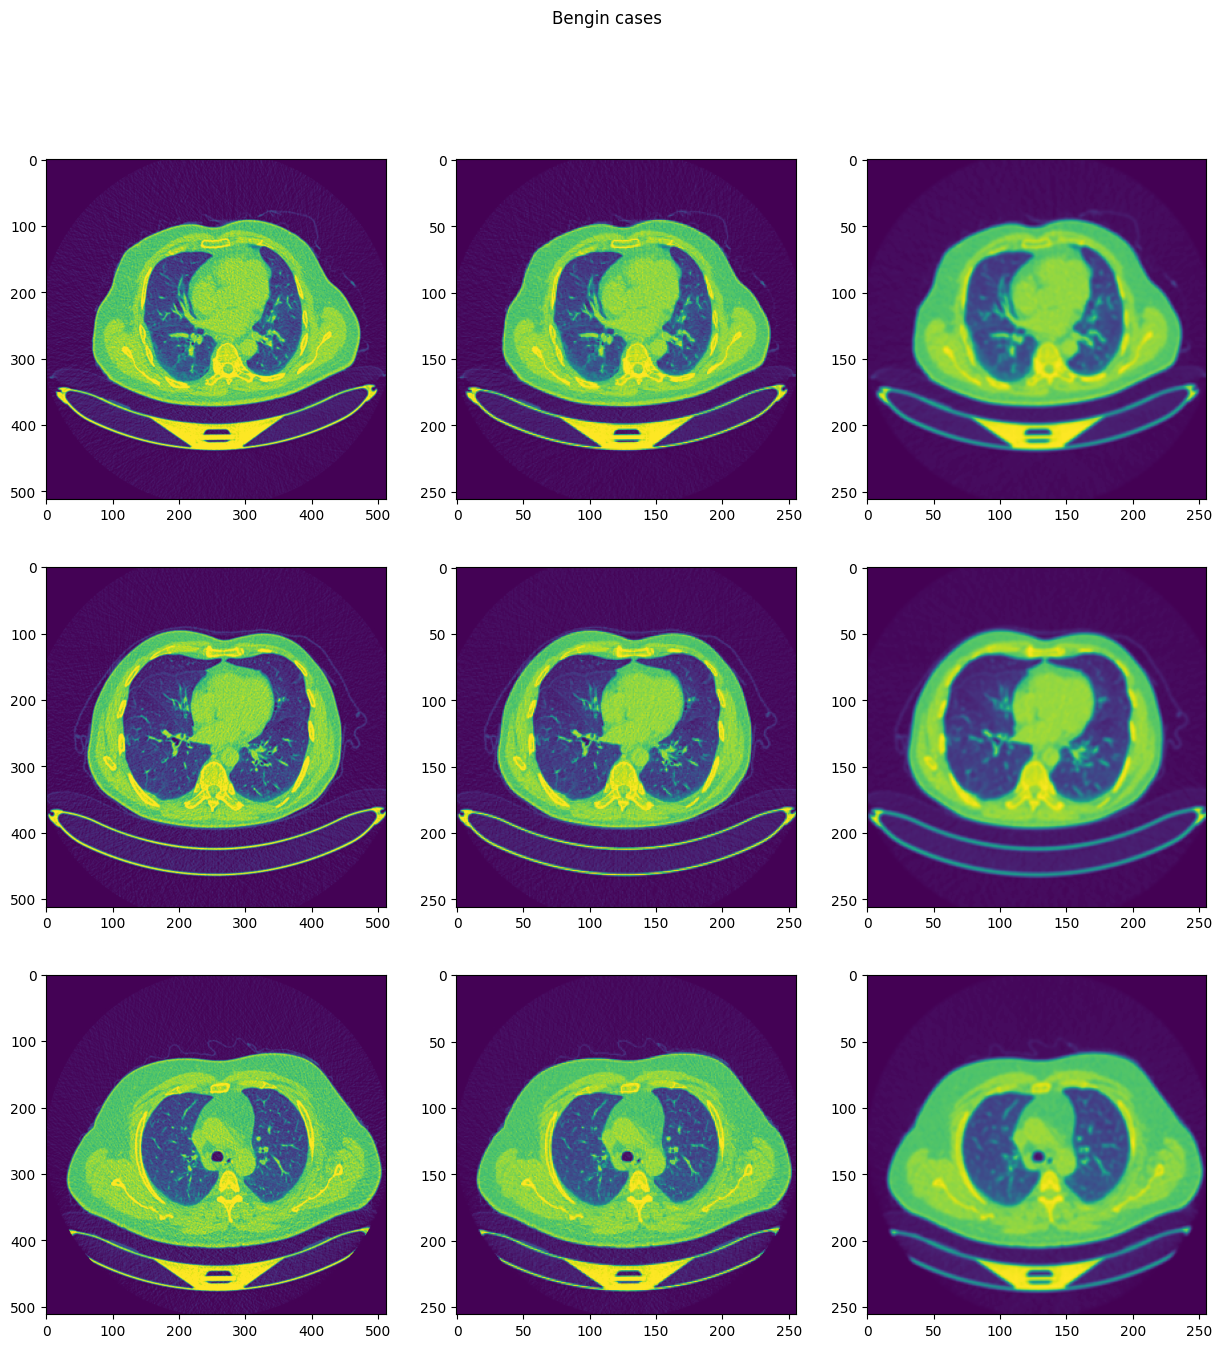

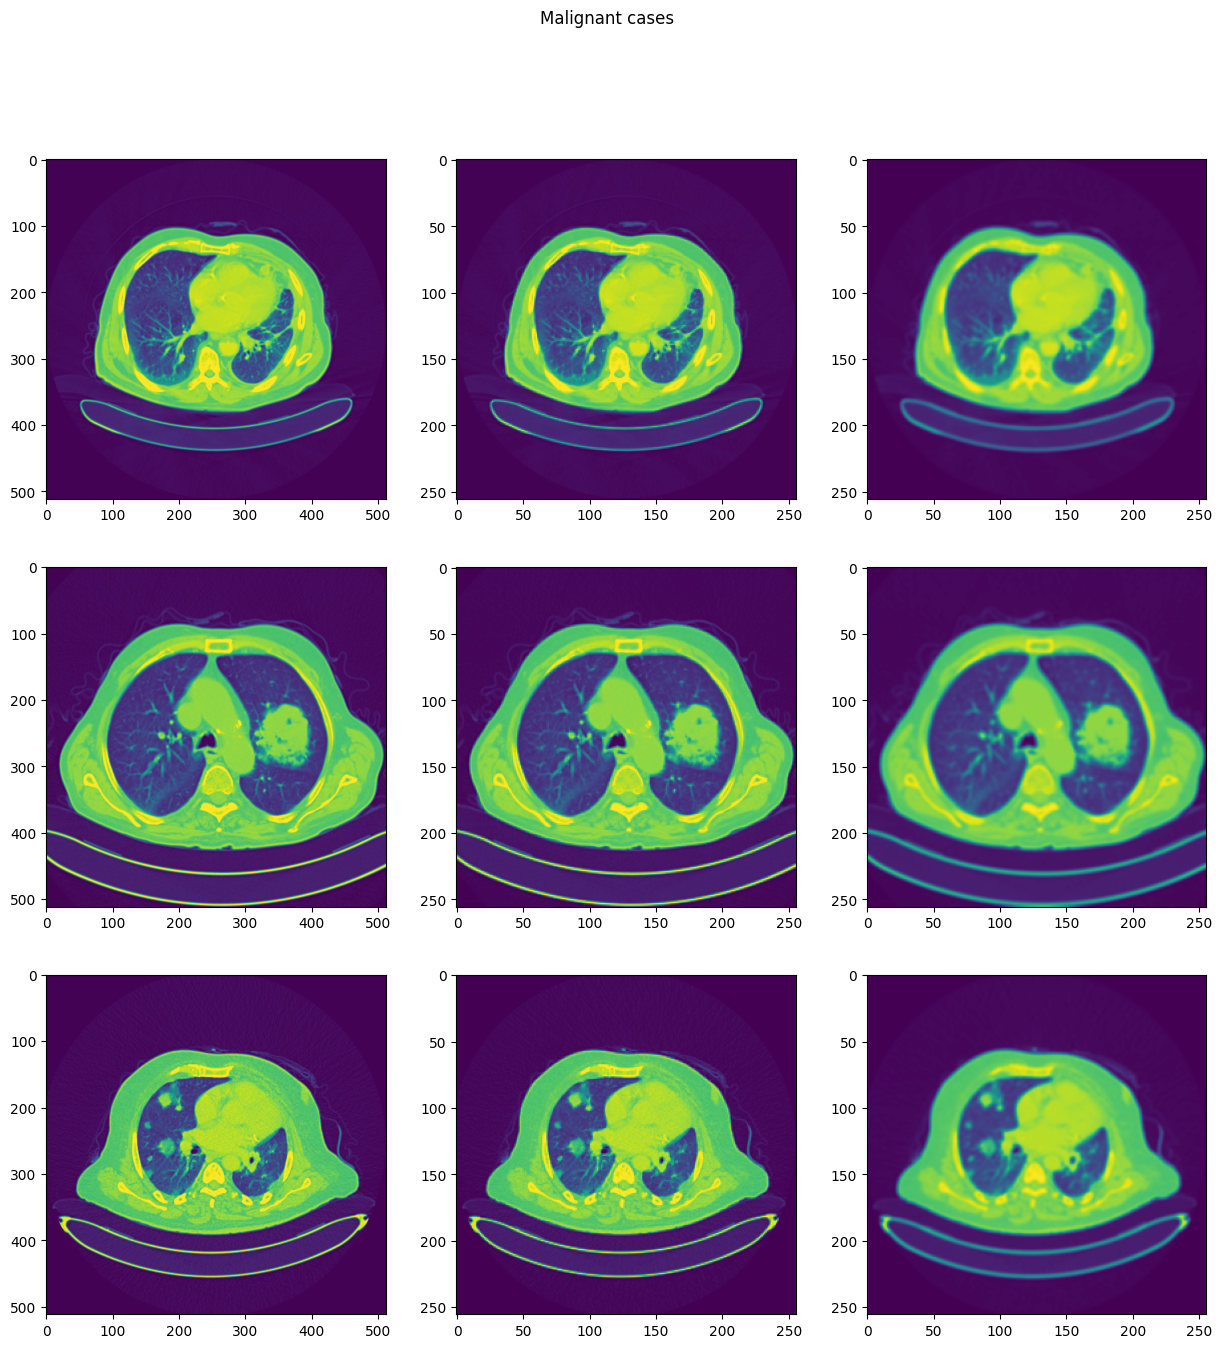

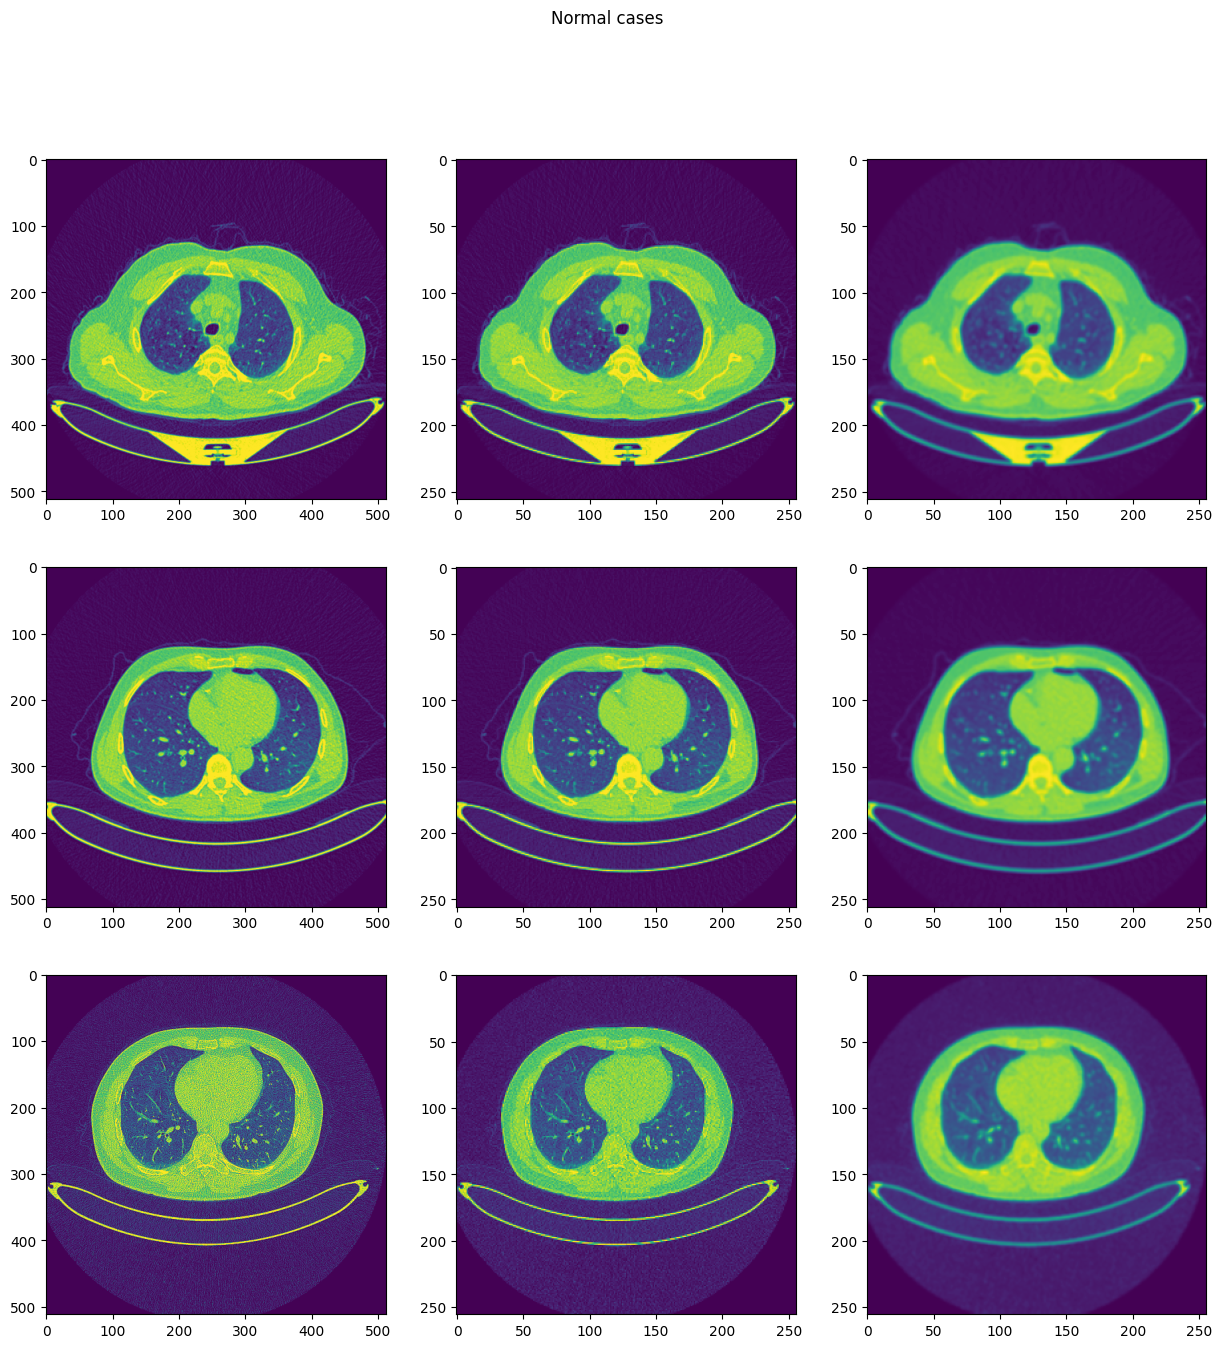

In [6]:
img_size = 256
for i in categories:
    cnt, samples = 0, 3
    fig, ax = plt.subplots(samples, 3, figsize=(15, 15))
    fig.suptitle(i)
    
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for curr_cnt, file in enumerate(os.listdir(path)):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)
        
        img0 = cv2.resize(img, (img_size, img_size))
        
        img1 = cv2.GaussianBlur(img0, (5, 5), 0)
        
        ax[cnt, 0].imshow(img)
        ax[cnt, 1].imshow(img0)
        ax[cnt, 2].imshow(img1)
        cnt += 1
        if cnt == samples:
            break
        
plt.show()

# Preparing Data

In [7]:
data = []
img_size = 256

for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)
        # preprocess here
        img = cv2.resize(img, (img_size, img_size))
        data.append([img, class_num])
        
random.shuffle(data)

X, y = [], []
for feature, label in data:
    X.append(feature)
    y.append(label)
    
print('X length:', len(X))
print('y counts:', Counter(y))

# normalize
X = np.array(X).reshape(-1, img_size, img_size, 1)
X = X / 255.0
y = np.array(y)

X length: 1097
y counts: Counter({1: 561, 2: 416, 0: 120})


In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=10, stratify=y)

print(len(X_train), X_train.shape)
print(len(X_valid), X_valid.shape)

822 (822, 256, 256, 1)
275 (275, 256, 256, 1)


# Applying SMOTE to oversample the data

In [9]:
print(Counter(y_train), Counter(y_valid))

Counter({np.int64(1): 420, np.int64(2): 312, np.int64(0): 90}) Counter({np.int64(1): 141, np.int64(2): 104, np.int64(0): 30})


In [10]:
print(len(X_train), X_train.shape)

X_train = X_train.reshape(X_train.shape[0], img_size*img_size*1)

print(len(X_train), X_train.shape)

822 (822, 256, 256, 1)
822 (822, 65536)


In [11]:
print('Before SMOTE:', Counter(y_train))
smote = SMOTE()
X_train_sampled, y_train_sampled = smote.fit_resample(X_train, y_train)
print('After SMOTE:', Counter(y_train_sampled))

Before SMOTE: Counter({np.int64(1): 420, np.int64(2): 312, np.int64(0): 90})
After SMOTE: Counter({np.int64(2): 420, np.int64(1): 420, np.int64(0): 420})


In [12]:
X_train = X_train.reshape(X_train.shape[0], img_size, img_size, 1)
X_train_sampled = X_train_sampled.reshape(X_train_sampled.shape[0], img_size, img_size, 1)

print(len(X_train), X_train.shape)
print(len(X_train_sampled), X_train_sampled.shape)

822 (822, 256, 256, 1)
1260 (1260, 256, 256, 1)


# Model Building with SMOTE data

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
mc = ModelCheckpoint(
    filepath="./model1.keras",
    monitor= 'val_accuracy',
    verbose= 1,
    save_best_only= True,
    mode = 'auto'
    )

call_back = [mc]
tensorboard = TensorBoard(log_dir = 'logs')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True, mode="max")

In [14]:
model1 = Sequential()

model1.add(Conv2D(64, (3, 3), input_shape=X_train.shape[1:]))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Flatten())
model1.add(Dense(16))
model1.add(Dense(3, activation='softmax'))

# model1.summary()

d:\my-proj\Belgis\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
model1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [16]:
history1 = model1.fit(X_train_sampled, y_train_sampled, batch_size=8, epochs=10, validation_data=(X_valid, y_valid), callbacks = [tensorboard, mc, reduce_lr, early_stopping])

Epoch 1/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.6179 - loss: 1.6765
Epoch 1: val_accuracy improved from -inf to 0.96727, saving model to ./model1.keras
158/158 ━━━━━━━━━━━━━━━━━━━━ 18s 111ms/step - accuracy: 0.6191 - loss: 1.6701 - val_accuracy: 0.9673 - val_loss: 0.1522 - learning_rate: 0.0010
Epoch 2/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9750 - loss: 0.0972
Epoch 2: val_accuracy improved from 0.96727 to 0.98182, saving model to ./model1.keras
158/158 ━━━━━━━━━━━━━━━━━━━━ 17s 108ms/step - accuracy: 0.9751 - loss: 0.0969 - val_accuracy: 0.9818 - val_loss: 0.0648 - learning_rate: 0.0010
Epoch 3/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9921 - loss: 0.0297
Epoch 3: val_accuracy improved from 0.98182 to 0.99636, saving model to ./model1.keras
158/158 ━━━━━━━━━━━━━━━━━━━━ 18s 111ms/step - accuracy: 0.9922 - loss: 0.0296 - val_accuracy: 0.9964 - val_loss: 0.0303 - learning_rate: 0.0010
Epoch 4/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 104

# Results

In [17]:
y_pred = model1.predict(X_valid, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_bool))

print(confusion_matrix(y_true=y_valid, y_pred=y_pred_bool))

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        30
           1       1.00      1.00      1.00       141
           2       1.00      0.99      1.00       104

    accuracy                           1.00       275
   macro avg       0.99      1.00      0.99       275
weighted avg       1.00      1.00      1.00       275

[[ 30   0   0]
 [  0 141   0]
 [  1   0 103]]


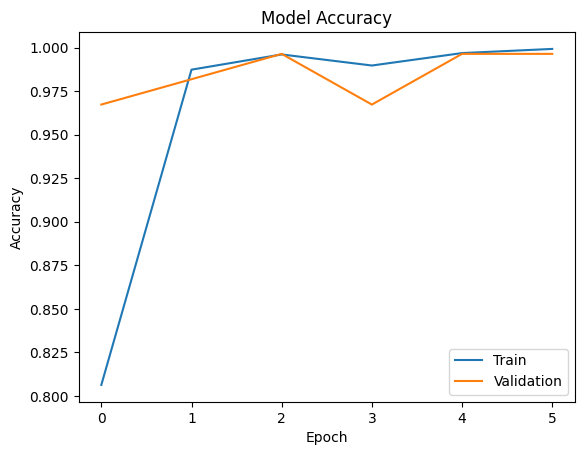

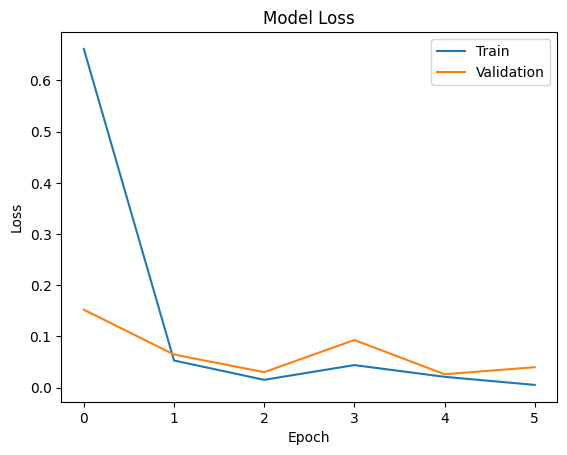

In [18]:
plt.plot(history1.history['accuracy'], label='Train')
plt.plot(history1.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history1.history['loss'], label='Train')
plt.plot(history1.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [19]:
model1.save('./model/sequential-model1.keras')

# Model Building with Class Weighted Approach

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
mc2 = ModelCheckpoint(
    filepath="./model2.keras",
    monitor= 'val_accuracy',
    verbose= 1,
    save_best_only= True,
    mode = 'auto'
    )

call_back2 = [mc]
tensorboard2 = TensorBoard(log_dir = 'logs')
reduce_lr2 = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

early_stopping2 = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True, mode="max")

In [22]:
model2 = Sequential()

model2.add(Conv2D(64, (3, 3), input_shape=X_train.shape[1:]))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Flatten())
model2.add(Dense(16))
model2.add(Dense(3, activation='softmax'))

# model2.summary()

d:\my-proj\Belgis\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [24]:
new_weights = {
    0: X_train.shape[0]/(3*Counter(y_train)[0]),
    1: X_train.shape[0]/(3*Counter(y_train)[1]),
    2: X_train.shape[0]/(3*Counter(y_train)[2]),
}

# new_weights[0] = 0.5
# new_weights[1] = 20

new_weights

{0: 3.0444444444444443, 1: 0.6523809523809524, 2: 0.8782051282051282}

In [25]:
history2 = model2.fit(X_train, y_train, batch_size=8, epochs=10, validation_data=(X_valid, y_valid), class_weight=new_weights, callbacks = [tensorboard2, mc2, reduce_lr2, early_stopping2])

Epoch 1/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.5717 - loss: 2.4413
Epoch 1: val_accuracy improved from -inf to 0.87636, saving model to ./model2.keras
103/103 ━━━━━━━━━━━━━━━━━━━━ 13s 119ms/step - accuracy: 0.5729 - loss: 2.4288 - val_accuracy: 0.8764 - val_loss: 0.2766 - learning_rate: 0.0010
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9598 - loss: 0.1432
Epoch 2: val_accuracy improved from 0.87636 to 0.98545, saving model to ./model2.keras
103/103 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - accuracy: 0.9599 - loss: 0.1429 - val_accuracy: 0.9855 - val_loss: 0.0788 - learning_rate: 0.0010
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.9881 - loss: 0.0530
Epoch 3: val_accuracy improved from 0.98545 to 0.99636, saving model to ./model2.keras
103/103 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - accuracy: 0.9881 - loss: 0.0532 - val_accuracy: 0.9964 - val_loss: 0.0520 - learning_rate: 0.0010
Epoch 4/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 103

# Results

In [26]:
y_pred = model2.predict(X_valid, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_bool))

print(confusion_matrix(y_true=y_valid, y_pred=y_pred_bool))

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        30
           1       1.00      1.00      1.00       141
           2       1.00      0.99      1.00       104

    accuracy                           1.00       275
   macro avg       0.99      1.00      0.99       275
weighted avg       1.00      1.00      1.00       275

[[ 30   0   0]
 [  0 141   0]
 [  1   0 103]]


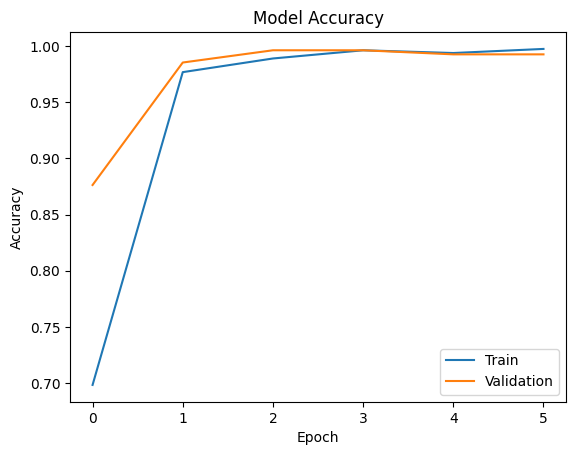

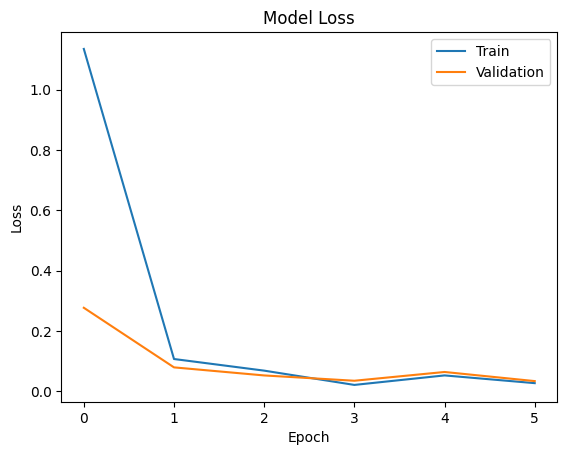

In [27]:
plt.plot(history2.history['accuracy'], label='Train')
plt.plot(history2.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()
plt.plot(history2.history['loss'], label='Train')
plt.plot(history2.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [28]:
model2.save('./model/sequential-model2.keras')

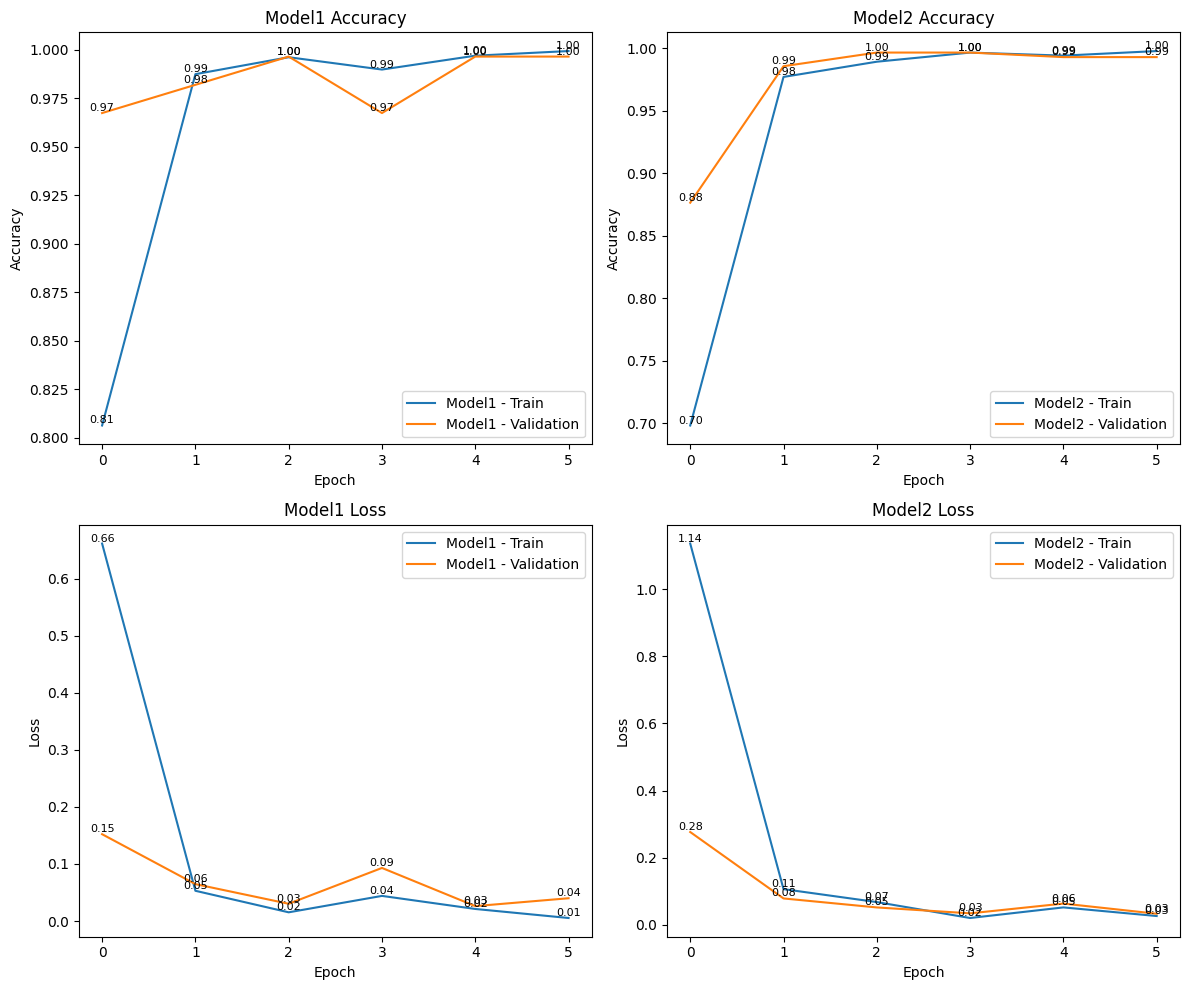

In [34]:
# Membuat plot untuk perbandingan accuracy dan loss antara model1 dan model2
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Gambar 1: Perbandingan accuracy untuk model1
axs[0, 0].plot(history1.history['accuracy'], label='Model1 - Train')
axs[0, 0].plot(history1.history['val_accuracy'], label='Model1 - Validation')
axs[0, 0].set_title('Model1 Accuracy')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].legend()

# Menambahkan nilai pada setiap titik di model1 accuracy
for i, acc in enumerate(history1.history['accuracy']):
    axs[0, 0].text(i, acc, f'{acc:.2f}', color='black', fontsize=8, ha='center', va='bottom')

for i, val_acc in enumerate(history1.history['val_accuracy']):
    axs[0, 0].text(i, val_acc, f'{val_acc:.2f}', color='black', fontsize=8, ha='center', va='bottom')

# Gambar 2: Perbandingan accuracy untuk model2
axs[0, 1].plot(history2.history['accuracy'], label='Model2 - Train')
axs[0, 1].plot(history2.history['val_accuracy'], label='Model2 - Validation')
axs[0, 1].set_title('Model2 Accuracy')
axs[0, 1].set_ylabel('Accuracy')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].legend()

# Menambahkan nilai pada setiap titik di model2 accuracy
for i, acc in enumerate(history2.history['accuracy']):
    axs[0, 1].text(i, acc, f'{acc:.2f}', color='black', fontsize=8, ha='center', va='bottom')

for i, val_acc in enumerate(history2.history['val_accuracy']):
    axs[0, 1].text(i, val_acc, f'{val_acc:.2f}', color='black', fontsize=8, ha='center', va='bottom')

# Gambar 3: Perbandingan loss untuk model1
axs[1, 0].plot(history1.history['loss'], label='Model1 - Train')
axs[1, 0].plot(history1.history['val_loss'], label='Model1 - Validation')
axs[1, 0].set_title('Model1 Loss')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].legend()

# Menambahkan nilai pada setiap titik di model1 loss
for i, loss in enumerate(history1.history['loss']):
    axs[1, 0].text(i, loss, f'{loss:.2f}', color='black', fontsize=8, ha='center', va='bottom')

for i, val_loss in enumerate(history1.history['val_loss']):
    axs[1, 0].text(i, val_loss, f'{val_loss:.2f}', color='black', fontsize=8, ha='center', va='bottom')

# Gambar 4: Perbandingan loss untuk model2
axs[1, 1].plot(history2.history['loss'], label='Model2 - Train')
axs[1, 1].plot(history2.history['val_loss'], label='Model2 - Validation')
axs[1, 1].set_title('Model2 Loss')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].legend()

# Menambahkan nilai pada setiap titik di model2 loss
for i, loss in enumerate(history2.history['loss']):
    axs[1, 1].text(i, loss, f'{loss:.2f}', color='black', fontsize=8, ha='center', va='bottom')

for i, val_loss in enumerate(history2.history['val_loss']):
    axs[1, 1].text(i, val_loss, f'{val_loss:.2f}', color='black', fontsize=8, ha='center', va='bottom')

# Menampilkan plot
plt.tight_layout()
plt.show()
